In [1]:
#!/usr/bin/python3
import sys
sys.path.insert(0, '../src/')

from ntree import *
from tree_vis import *

import numpy as np
import matplotlib.pyplot as plt

upper size limit->float
lower size limit-> base nodes
efficiency limit-> worst and best case scenario-> base nodes
uniform matching

Our initial goal was to bring better results than a uniform discretization by taking advantage of the regions of interest. So we will use as **efficiency the ratio of this decrease**. But it is too complex to compute the theoretical values of the uniform one. Though, the initial tree, before any adaption, is uniform, so we can use the $ME$ of this. The efficiency then will be $\frac{ME\ after\ adaption}{ME\ before\ adaption}$.

### Limitations and efficiency
As this method brings good results, it has its limitations and its weaknesses. Usually, vulnerabilities are a result of restrictions and rules in a system. In our case, each point has a fixed position predetermined by the geometry of the tree. Root will always be in the middle of the space, sub-branches will always split the space in the same sub-spaces, etc. And Usually our set of discrete points is forced to have some points that are not essential for decreasing the $ME$, but are the base nodes under a sub-tree that does. So we can divide all the nodes into 2 sets. The **base nodes** and the nodes that actually decrease the $ME$ which we call **optimizer nodes**. Some nodes may belong to both sets, for example root is for sure a base node but it can be an optimizer too in case that the PDF is near the middle of the space. 


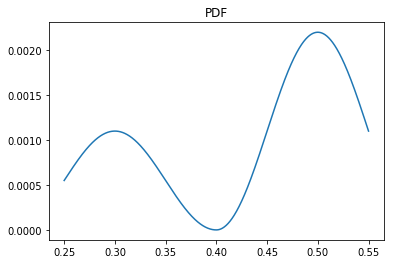

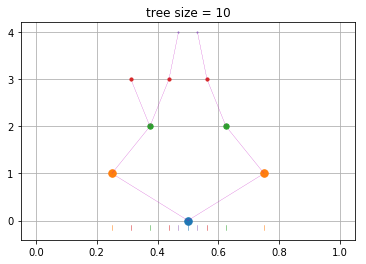

In [2]:
tree_dims = 1
tree_size = 10 
x = np.linspace(0, 1, 1000)
x_offset = 0.25
pdf = np.sin(3*np.pi*x)+1
pdf = np.multiply(pdf, list((1 if x_i>0.5 else 0.5) for x_i in x))
pdf = pdf / np.sum(pdf)
samples = x_offset+0.3*np.random.choice(x, len(x) ,p=pdf).reshape((len(x), tree_dims))
plt.title("PDF")
plt.plot(x_offset+x*0.3, pdf)
plt.show()

tree = Tree(tree_dims, tree_size)

count = 0
tree.feed(samples)
ME = [tree.get_mean_error()]

while tree.update() and count < 20:
    tree.feed(samples)
    ME.append(tree.get_mean_error())
    count+=1
tree.plot()

We can see in the example above the PDF we try to match how the nodes take part. Root is both base and optimizer, while node $[0.75]$ is completely out the range of the PDF. Node $[0.25]$ is inside the range, but it is not helping that much. If the algorithm wasn't forced to created it, maybe it wouldn't.

#### Size limits
Of course the nodes that are only base nodes are completely useless and take up space from optimizers. The ratio of the optimizers to the base nodes **affects directly the efficiency to size ratio**. The real problem with the base nodes is on the first few levels and depends strongly to the PDF we want to approach too. If we want to approach a complex PDF with very few nodes we will end up with most of the $k$ points wasted as base nodes. On the other side, for a big tree the base nodes comparing to the optimizers are too few, and won't produce any significant error for any PDF. So we conclude that **this method has a lower size limit, depending the PDF**, and needs a relatively great number of points in order to be efficient enough.

On the other hand, as we said before, each expansion subdivides the space of the last parent in $2^n$ equal n-dimensional cubes. Each axis breaks into two, so if the parent node had a region with volume $d^n$ (where $d$ is the length of each cube's edge), the children will have a region with volume $(\frac{d}{2})^n$. And there it comes the constrain of the precision of computers floating point representation. After a point, we run out of digits and the subdivision fails as each cube has $d=0$, and the points have the same locations. The maximum number of points that we can have depends again to the PDF and to the digits of float and the precision it can reach. So there is an __upper limit__ too. There are plenty of solutions to this problem but we are not going to dig into them since this limit is very high and doesn't affect the presentation of our method. Nodes are scaling exponentially proportional to the level of the tree and even for $n=1$ we have more than one millions at level 20, and we are not even close to the limit.  

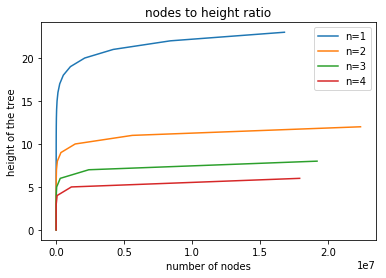

In [11]:
### nodes to height ratio
def nodes_at_height(h, n):
    count = 0
    for i in range(h+1):
        count += 2**(n*i)
    return count

for n in range(1, 5):
    x = []
    y = []
    for height in range(30):
        nodes = nodes_at_height(height, n)
        y.append(height)
        x.append(nodes)
        if nodes > 10000000:
            break
    plt.plot(x, y, label='n={}'.format(n))
plt.title('nodes to height ratio')
plt.xlabel('number of nodes')
plt.ylabel('height of the tree')
plt.legend()
plt.show()

#### Efficiency limits
Before analyzing the efficiency limits, it's important to note that we will speak for average cases. There are some special cases that don't belong to this analysis. For example there is a possibility for the PDF to be some actual points that may or may not match with the discrete ones, or some that the user feedback before the update was not stable. Here we assume that user will sample the right amount of random points that represent decently the PDF and also that the tree has the potential (size and enough updates) to adapts this PDF.

It is impossible for our method to match exactly with the optimal set of discrete points that bring the minimum possible $ME$ because our points aren't moving freely into space. But it all depends to their total number. It is like discretization of a continuous function. As the sensitivity grows, the error drops. So as soon as we have enough points to place, we can get close enough to the optimal solution. And the actual value of the efficiency depends on the PDF itself and range that is spread into. It's different to try to spread all the discrete points through the whole space, than caring about a small portion of it. You will end up with a taller tree with the same number of points. So the conclusion is that **there is no actual upper limit on the efficiency** that has to do with this method.

Also, because the **uniform discretization** is also possible, we can use it as **lower limit** of our efficiency. Which means that our method can only make things better. Here we have to mention one slight weakness of this approach. After a node expands, new points are created in the middle of the $2^n$ new cubes. Combined with the parent point we have a distribution that is not that uniform as it has more points in the middle. So when trying to approach a uniform PDF there will always be a slightly less density in the edges. 

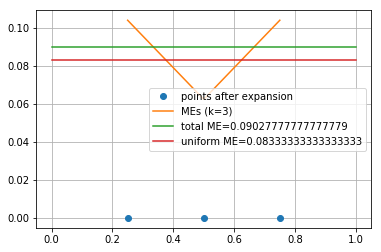

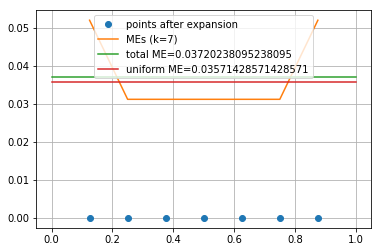

In [41]:
# the ME formula for n=1 
def ME_i(x_i, a, b):
    return (x_i**2 - (a+b)*x_i + (a**2 + b**2)/2)/(b-a)
# calculating all MEs for a set of points
def MEs(points, a=0, b=1):
    points = np.sort(points.flatten())
    ranges = [a]
    for i in range(len(points)-1):
        ranges.append((points[i+1]+points[i])/2)
    ranges.append(b)
    return list(ME_i(points[i], a=ranges[i], b=ranges[i+1]) for i in range(len(points)))
# the formula of uniform's distribution ME
def uniform_ME(k, a=0, b=1):
    return (b-a)/(4*k)

k=3
tree = Tree(1, k)
points = np.sort(tree.get_points().flatten())
ME_s = MEs(points)
plt.plot(points, np.zeros(k), 'o', label='points after expansion')
plt.plot(points, ME_s, label='MEs (k={})'.format(k))
plt.plot([0, 1], [np.average(ME_s)]*2, label='total ME={}'.format(np.average(ME_s)))
plt.plot([0, 1], [uniform_ME(k)]*2, label='uniform ME={}'.format(uniform_ME(k)))
plt.legend()
plt.grid(True)
plt.show()

k=7
tree = Tree(1, k)
points = np.sort(tree.get_points().flatten())
ME_s = MEs(points)
plt.plot(points, np.zeros(k), 'o', label='points after expansion')
plt.plot(points, ME_s, label='MEs (k={})'.format(k))
plt.plot([0, 1], [np.average(ME_s)]*2, label='total ME={}'.format(np.average(ME_s)))
plt.plot([0, 1], [uniform_ME(k)]*2, label='uniform ME={}'.format(uniform_ME(k)))
plt.legend()
plt.grid(True)
plt.show()


As we can see, for greater $k$ the difference between total $ME$ and uniform $ME$ is shrinking. It actually becomes indistinguishable very fast. 

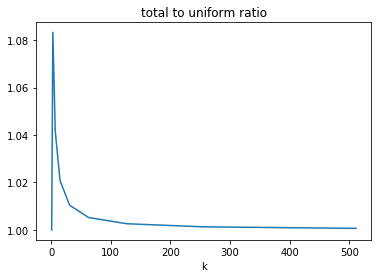

In [54]:
total_MEs = []
uniform_MEs = []
ks = []
for i in range(1, 10):
    k = 2**i-1
    tree = Tree(1, k)
    points = tree.get_points()
    ks.append(k)
    total_MEs.append(np.average(MEs(points)))
    uniform_MEs.append(uniform_ME(k))

ratios = np.divide(total_MEs, uniform_MEs)
plt.plot(ks, ratios)
plt.title('total to uniform ratio')
plt.xlabel('k')
plt.show()

We can see that this error peaks for $k=3$ and quickly drops to almost zero. 